# Geoinformatics Project
---
# LEO satellites orbits simulator
###### Angelica Iseni, Emma Lodetti

The **goal** of this project is to compute the position of each LEO (Low Earth orbit) satellite in the constellation for every second of the day.

In this script you will be asked to enter: 
- The **number of orbital planes** of the costellation
- The **number of satellites** per orbital plane
- The **inclination** of the orbital planes with respect to the reference equatorial plane

This information will be used to create almanacs of the constellation satellites.

In [10]:
# Import libraries
import ipywidgets as widgets
from IPython.display import display
from IPython.display import FileLink
import os

# Useful for defining quantities
from astropy import units as u

# Earth focused modules
from poliastro.earth import EarthSatellite
from poliastro.earth.plotting import GroundtrackPlotter
from poliastro.examples import iss
from poliastro.util import time_range

from poliastro.bodies import Earth
from poliastro.twobody import Orbit

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import math as mt
import pyproj

### Function definition

In [2]:
# input parameters function
def user_input(var):
    
    n_orbits = num_orbits.value
    n_satellites = num_satellites.value
    inclination = orbit_inclination.value
    
    if n_orbits < 0 or n_satellites < 0 or inclination < 0:
        print('Error: The numbers cannot be negative. Please insert valid numbers.')
    else:
        print(f'You have selected {n_orbits} orbital planes with {n_satellites} satellites each, with an inclination of {inclination} degrees.')

name_list = []
        
# txt creation function
def create_satellite_txt(i_orbit, i_satellite):
    
    # Satellite name creation as "LEO XXYY", where XX = orbit number and YY = satellite number
    satellite_name = f'LEO{i_orbit:02}{i_satellite:02}'
    name_list.append(satellite_name)
    
    # M0 computation
    M0 = 360 / num_satellites * (i_satellite - 1) + 360 / num_satellites * ((i_orbit - 1) / num_orbits)
    
    # Omega0 computation
    Omega0 = (i_orbit - 1) * 180 / num_orbits
    
    # Almanac content
    output_content = f'SatelliteName {satellite_name}\nOrbitRadius {orbit_radius}\nOrbitInclination {inclination}\nM0 {M0}\nOmega0 {Omega0}'
    
    # txt file path
    file_path = f'Almanacs{num_orbits:02}{num_satellites:02}{inclination:02}/{satellite_name}.txt'
    
    # Write content in txt file
    with open(file_path, 'w') as file:
        file.write(output_content)
        
    # Return list of satellite nemes for plot selection
    return name_list


### Input parameters
Insert number of orbits, number of satellites per orbit and inclination of the orbit.

In [ ]:
# Widget creation
style = {'description_width': 'initial'}
num_orbits = widgets.IntText(description='Number of orbits:', value=0, style=style)
num_satellites = widgets.IntText(description='Number of satellites per orbit:', value=0, style=style)
orbit_inclination = widgets.FloatSlider(description='Orbit inclination:', min=0, max=90, step=1, style=style)
    
# Submit button
submit_button = widgets.Button(description='Submit')
submit_button.on_click(user_input)

display(num_orbits, num_satellites, orbit_inclination, submit_button)

### Folders and Almanacs creation as txt files

In [ ]:
# Convert values to integers
num_orbits = int(num_orbits.value)
num_satellites = int(num_satellites.value)
inclination = int(orbit_inclination.value)

# Almanac folder creation
# "AlmanacsXXYYZZ": XX = number of orbital planes, YY = number of satellites per orbital plane, ZZ = inclination of orbital planes
if not os.path.exists(f'Almanacs{num_orbits:02}{num_satellites:02}{inclination:02}'):
    os.makedirs(f'Almanacs{num_orbits:02}{num_satellites:02}{inclination:02}')

# Satellite positon output folder creation
# "SatellitePositionsXXYYZZ": XX = number of orbital planes, YY = number of satellites per orbital plane, ZZ = inclination of orbital planes
if not os.path.exists(f'SatellitePositions{num_orbits:02}{num_satellites:02}{inclination:02}'):
    os.makedirs(f'SatellitePositions{num_orbits:02}{num_satellites:02}{inclination:02}')
    out_folder_name = f'SatellitePositions{num_orbits:02}{num_satellites:02}{inclination:02}'

# Orbital radius definition
orbit_radius = 7180 #km

# for cycle on orbit number
for i_orb in range(1, num_orbits + 1):
    # for cycle on satellite number per orbit
    for i_sat in range(1, num_satellites + 1):
        sat_name_list = create_satellite_txt(i_orb, i_sat)
        
print(f'Almanacs created successfully!')

### Plot Ground Tracks

In [ ]:
# Load background image
#background_image_path = r'D:\Satellite Code\earth.jpg'
#background_img = plt.imread(background_image_path)

# Create the plot
plt.figure(figsize=(15.2, 8.2))
#plt.imshow(background_img, extent=[-180, 180, -90, 90])

# Create a Basemap instance
m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawmeridians(np.arange(-180, 180, 30))
m.drawparallels(np.arange(-90, 90, 30))

# Plot the ground track
x, y = m(data['longitude'], data['latitude'])
m.plot(x, y, 'r.', linewidth=1)

#plt.scatter(data['longitude'], data['latitude'], color='red', marker='o', s=4)
#plt.xlabel("Longitude (degrees)")
#plt.ylabel("Latitude (degrees)")
#plt.title("BEESAT 9 Ground Track ")

# Show the plot
#plt.legend()
plt.grid(True, color='w', linestyle=":", alpha=0.4)
plt.show()

In [ ]:
# Plot selection
plot_sat = widgets.Dropdown(
            options = sat_name_list,
            value = sat_name_list[0],
            description='Select satellite:',
            disabled = False,
            style = style,
            )

display(plot_sat)

In [ ]:
# Import and plot coordinates from Output folder

# Load the data from the file selected

path = out_folder_name + '/' + plot_sat.value + '.txt'
data = pd.read_csv(path, sep=' ', header=None, names=['latitude', 'longitude', 'height'])

# Create the plot
plt.figure(figsize=(15.2, 8.2))

# Create a Basemap instance
m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawmeridians(np.arange(-180, 180, 30))
m.drawparallels(np.arange(-90, 90, 30))

# Plot the ground track
x, y = m(data['longitude'], data['latitude'])
m.plot(x, y, 'r.', linewidth=1)

# Show the plot
plt.grid(True, color='w', linestyle=":", alpha=0.4)
plt.show()

In [7]:
data = pd.read_csv(f'SatellitePositions050530\LEO0101.txt', sep=' ', header=None, names=['latitude', 'longitude', 'height'])

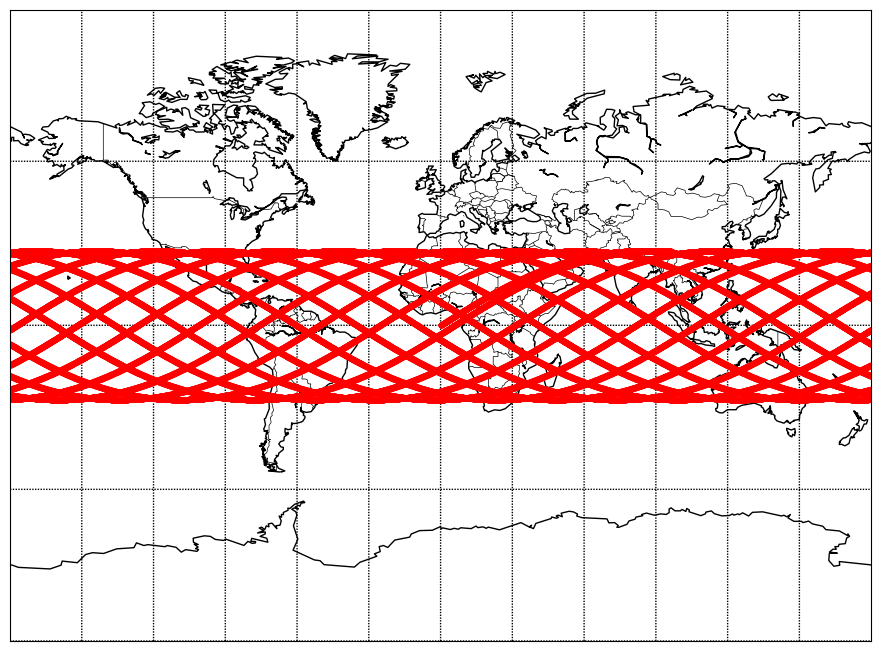

In [4]:
# Create the plot
plt.figure(figsize=(15.2, 8.2))

# Create a Basemap instance
m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawmeridians(np.arange(-180, 180, 30))
m.drawparallels(np.arange(-90, 90, 30))

# Plot the ground track
x, y = m(data['longitude'], data['latitude'])
m.plot(x, y, 'r.', linewidth=1)

# Show the plot
plt.grid(True, color='w', linestyle=":", alpha=0.4)
plt.show()

In [9]:
# Separate latitude, longitude, and altitude
lat = data['latitude'] 
lon = data['longitude']
alt = data['height']

# Create a Proj object for converting geodetic to ECEF
geodetic_to_ecef = pyproj.Transformer.from_crs(
    'EPSG:4979', 'EPSG:4326', always_xy=True)

# Convert lat, lon, alt to ECEF
ecef_data = np.zeros((len(lat), 3))
for i in range(len(lat)):
    ecef_data[i] = geodetic_to_ecef.transform(lon[i], lat[i], alt[i])

# Calculate velocity by differencing position vectors
velocity = np.zeros((len(lat) - 1, 3))
for i in range(len(lat) - 1):
    velocity[i] = (ecef_data[i + 1] - ecef_data[i]) / (1 / 3600)

print(velocity)

[[  170.3283383    107.66329887    20.81476087]
 [  170.32843811   107.66321121    62.44418873]
 [  170.32863773   107.66303591   104.07335381]
 ...
 [  230.91476109   -14.98028316 -4814.1046477 ]
 [  230.89431435   -15.10702734 -4854.4187651 ]
 [  230.8737006    -15.23373975 -4894.71202455]]


In [14]:
r = data << u.km
v = velocity << u.km / u.s

orb = Orbit.from_vectors(Earth, r, v)

ValueError: Vectors must have dimension 1, got 2 and 2

In [ ]:
iss_spacecraft = EarthSatellite(iss, None)
t_span = time_range(
   iss.epoch - 1.5 * u.h, periods=150, end=iss.epoch + 1.5 * u.h
)

# Generate an instance of the plotter, add title and show latlon grid
gp = GroundtrackPlotter()
gp.update_layout(title="International Space Station groundtrack")

# Plot previously defined EarthSatellite object
gp.plot(
    iss_spacecraft,
    t_span,
    label="ISS",
    color="red",
    marker={
        "size": 10,
        "symbol": "triangle-right",
        "line": {"width": 1, "color": "black"},
    },
)

In [ ]:
# Switch to three dimensional representation
gp.update_geos(projection_type="orthographic")
gp.fig.show()

### Codici di prova

In [ ]:
# prova per far scrivere al codice i vari satelliti ma non va, riproverò

print(f'Orbits has radius = {orbit_radius} km and inclination = {inclination} degrees.')
# for cycle on orbit number
for i_orb in range(1, num_orbits + 1):
    # for cycle on satellite number per orbit
    for i_sat in range(1, num_satellites + 1):
        create_satellite_txt(i_orb, i_sat)
        print(f'Satellite {satellite_name} on orbital plane {i_orb}: M0 = {M0} degrees.')
    print(f'Orbital plane {i_orb}: Omega0 = {Omega0} degrees.')

In [ ]:
# Build spacecraft instance
iss_spacecraft = EarthSatellite(iss, None)
t_span = time_range(
    iss.epoch - 1.5 * u.h, periods=150, end=iss.epoch + 1.5 * u.h
)

In [ ]:
num_orbits = int(num_orbits.value)
num_satellites = int(num_satellites.value)
inclination = int(orbit_inclination.value)